# Visualizing features with captum.optim

This notebook demonstrates the use of the `captum.optim` submodule for visualizing features for a InceptionV1 model imported from Caffe. The `optim` submodule shows the increasing complexity of the features learned as we go deeper into the model. We also briefly touch on the `ImageTensor` class for easily loading and visualizing tensors that are also images.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from captum.optim._models.inception_v1 import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## ImageTensor

The `ImageTensor` class is a wrapper around `torch.Tensor` that allows for easy loading and viewing of images.

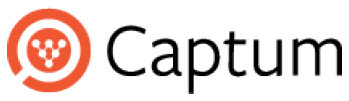

In [ ]:
# Use ImageTensor.open() with a URL or filepath to load an image
t = optimviz.ImageTensor.open(
    "https://raw.githubusercontent.com/pytorch/captum/master/website/static/img/captum_logo.png"
)
# Use show() to quickly view the image.
t.show()

## InputOptimization

`InputOptimization` is the core function for visualizing features with `captum.optim`.

It takes five arguments:
- The model whose feature(s) we are visualizing
- A torch.nn.Module object that generates inputs to the model (e.g. NaturalImage)
- A transformation or series of transformations preprocessing the input before passing to the model
- A list of target layers from the model
- A loss function based on the target layers

/content/captum/captum/optim/_param/image/images.py:256: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  output = torch.irfft(scaled_spectrum, signal_ndim=2)[:, :h, :w]
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:775: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:848.)
  return super(Tensor, self).refine_names(names)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old

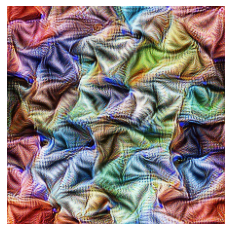

In [ ]:
# Load the model
model = googlenet(pretrained=True).to(device)

# Initialize an input - NaturalImage uses FFT parameterization and color decorrelation
image = optimviz.images.NaturalImage((224, 224)).to(device) # This creates a Module that returns an ImageTensor

# Initialize a series of transformations
transforms = torch.nn.Sequential(
    # Random translation, scaling, and rotation to help with visualization quality.
    # Padding is used to avoid transform artifacts and then it's cropped away.
    torch.nn.ReflectionPad2d(16),
    optimviz.transform.RandomSpatialJitter(16),
    optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    torchvision.transforms.RandomRotation(degrees=(-5,5)),
    optimviz.transform.RandomSpatialJitter(8),
    optimviz.transform.CenterCrop(16),
)
# Choose a target layer to optimize
target = model.mixed4c

# Create a loss function based on the target layer
loss_fn = optimviz.loss.ChannelActivation(target, 368)

# Initialize InputOptimization and run optimize
obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
history = obj.optimize(optimviz.objectives.n_steps(128))

image().show()

For convenience, we can create a helper function for visualizing different layers in our model.

In [ ]:
def visualize(model, target, channel):
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(16),
        optimviz.transform.RandomSpatialJitter(16),
        optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.CenterCrop(16),
    )
    loss_fn = optimviz.loss.ChannelActivation(target, channel)
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128))
    image().show()

With visualization, we can see that deeper features detect for increasingly complex elements.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


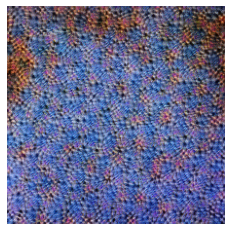

In [ ]:
visualize(model, model.mixed3a.conv_5x5_relu, 15)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


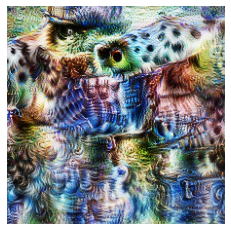

In [ ]:
visualize(model, model.mixed5b.conv_5x5, 19)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


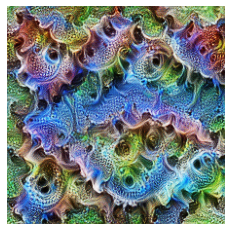

In [ ]:
visualize(model, model.mixed4d.conv_1x1, 21)

We can also visualize different classes in the final layer and see how they are similar to their corresponding ImageNet labels.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


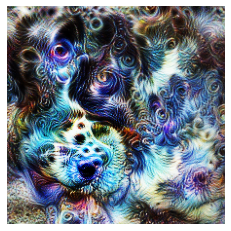

In [ ]:
visualize(model, model.fc, 5) # No idea what this class is

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


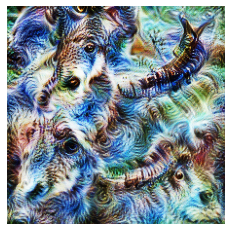

In [ ]:
visualize(model, model.fc, 9) # Some sort of animal?

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


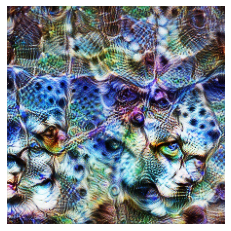

In [ ]:
visualize(model, model.fc, 11)